2000-01 not found.


<ipython-input-4-7cfe980cb3ed>:61: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  merged_df['Date'] = pd.to_datetime(merged_df['Date'], errors='coerce')
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the nu

Results for kNN
Accuracy: 0.6399082568807339
Confusion Matrix:
 [[ 70  40  16]
 [ 39  69   4]
 [ 30  28 140]]
Classification Report:
               precision    recall  f1-score   support

           A       0.50      0.56      0.53       126
           D       0.50      0.62      0.55       112
           H       0.88      0.71      0.78       198

    accuracy                           0.64       436
   macro avg       0.63      0.63      0.62       436
weighted avg       0.67      0.64      0.65       436

Results for Logistic Regression
Accuracy: 0.6422018348623854
Confusion Matrix:
 [[ 59  56  11]
 [ 24  79   9]
 [ 33  23 142]]
Classification Report:
               precision    recall  f1-score   support

           A       0.51      0.47      0.49       126
           D       0.50      0.71      0.59       112
           H       0.88      0.72      0.79       198

    accuracy                           0.64       436
   macro avg       0.63      0.63      0.62       436
weighted 

<ipython-input-4-7cfe980cb3ed>:153: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=models, y=accuracies, palette='viridis')


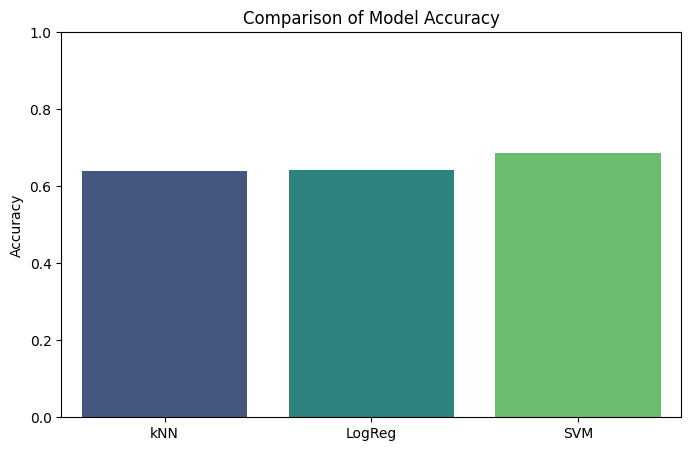

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from imblearn.over_sampling import SMOTE


folder_path = '/content'
years = [f"{y}-{str(y+1)[-2:]}" for y in range(2000, 2019)] + ['2018-19', '2019-20']

# Important match stats + betting odds
common_columns = [
    'Date', 'HomeTeam', 'AwayTeam',
    'FTHG', 'FTAG', 'FTR',
    'HS', 'AS', 'HST', 'AST', 'HF', 'AF', 'HC', 'AC',
    'HY', 'AY', 'HR', 'AR',
    'B365H', 'B365D', 'B365A'  # Betting odds added
]

standings_df = pd.read_csv('/content/EPLStandings.csv')
# Convert Standings to Long Format
standings_long = standings_df.melt(id_vars=['Team'], var_name='Season', value_name='Standing')

# Convert Standings to Long Format
standings_long = standings_df.melt(id_vars=['Team'], var_name='Season', value_name='Standing')

all_matches = []
for year in years:
    try:
        df = pd.read_csv(f"{folder_path}/{year}.csv")
        df = df[[col for col in common_columns if col in df.columns]]
        df['Season'] = year
        all_matches.append(df)
    except FileNotFoundError:
        print(f"{year} not found.")

merged_df = pd.concat(all_matches, ignore_index=True)
merged_df['SeasonStart'] = merged_df['Season'].str[:4]


# Merge Home and Away Standings
merged_df = merged_df.merge(standings_long, how='left', left_on=['HomeTeam', 'SeasonStart'], right_on=['Team', 'Season'])
merged_df.rename(columns={'Standing': 'HomeStanding'}, inplace=True)
for col in ['Team', 'Season']:
    if col in merged_df.columns:
        merged_df.drop(columns=col, inplace=True)

merged_df = merged_df.merge(standings_long, how='left', left_on=['AwayTeam', 'SeasonStart'], right_on=['Team', 'Season'])
merged_df.rename(columns={'Standing': 'AwayStanding'}, inplace=True)
merged_df.drop(columns=['Team', 'Season'], inplace=True)

# Compute Standing Difference
merged_df['StandingDiff'] = merged_df['HomeStanding'] - merged_df['AwayStanding']

# Convert Date to Datetime and Sort Matches
merged_df['Date'] = pd.to_datetime(merged_df['Date'], errors='coerce')
merged_df = merged_df.sort_values(by='Date').reset_index(drop=True)

# Assign MatchResult Labels
def get_result(row):
    if row['FTHG'] > row['FTAG']:
        return 'H'
    elif row['FTHG'] < row['FTAG']:
        return 'A'
    else:
        return 'D'

merged_df['MatchResult'] = merged_df.apply(get_result, axis=1)

# Calculate Win/Loss Streaks
def calculate_streaks(df, team_col, result_col):
    streak = []
    team_history = {}

    for _, row in df.iterrows():
        team = row[team_col]
        history = team_history.get(team, [])

        # Count continuous wins/losses
        streak_value = sum(1 for res in reversed(history) if res == row[result_col])
        streak.append(streak_value)

        team_history.setdefault(team, []).append(row[result_col])

    return streak

merged_df['HomeWinStreak'] = calculate_streaks(merged_df, 'HomeTeam', 'MatchResult')
merged_df['AwayWinStreak'] = calculate_streaks(merged_df, 'AwayTeam', 'MatchResult')


# Select Features & Target
features = ['HomeWinStreak', 'AwayWinStreak', 'StandingDiff', 'B365H', 'B365D', 'B365A']
target = 'MatchResult'

# Prepare Model Dataset
model_df = merged_df[features + [target]].dropna()

# Split Data
X = model_df[features]
y = model_df[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Apply Hybrid Oversampling (SMOTE + Undersampling majority classes)
smote = SMOTE( random_state=42)
X_train, y_train = smote.fit_resample(X_train, y_train)


# Hyperparameter Tuning with GridSearch
param_grid_knn = {'n_neighbors': [3, 5, 7]}
param_grid_svm = {'kernel': ['linear', 'rbf'], 'C': [0.1, 1, 10]}
param_grid_log_reg = {'C': [0.1, 0.5, 1], 'solver': ['liblinear', 'lbfgs']}

# KNN
grid_knn = GridSearchCV(KNeighborsClassifier(), param_grid_knn, cv=5)
grid_knn.fit(X_train, y_train)
knn_preds = grid_knn.best_estimator_.predict(X_test)

# Logistic Regression
grid_log = GridSearchCV(LogisticRegression(max_iter=1000), param_grid_log_reg, cv=5)
grid_log.fit(X_train, y_train)
log_preds = grid_log.best_estimator_.predict(X_test)

# SVM
grid_svm = GridSearchCV(SVC(), param_grid_svm, cv=5)
grid_svm.fit(X_train, y_train)
svm_preds = grid_svm.best_estimator_.predict(X_test)


def evaluate_model(name, y_true, y_pred):
    print(f"Results for {name}")
    print("Accuracy:", accuracy_score(y_true, y_pred))
    print("Confusion Matrix:\n", confusion_matrix(y_true, y_pred))
    print("Classification Report:\n", classification_report(y_true, y_pred))

evaluate_model("kNN", y_test, knn_preds)
evaluate_model("Logistic Regression", y_test, log_preds)
evaluate_model("SVM", y_test, svm_preds)


models = ['kNN', 'LogReg', 'SVM']
accuracies = [
    accuracy_score(y_test, knn_preds),
    accuracy_score(y_test, log_preds),
    accuracy_score(y_test, svm_preds)
]

plt.figure(figsize=(8, 5))
sns.barplot(x=models, y=accuracies, palette='viridis')
plt.title('Comparison of Model Accuracy')
plt.ylabel('Accuracy')
plt.ylim(0, 1)
plt.show()